# Mughilan Muthupari - Final Project: Indian Premier League
The Indian Premier League (IPL) is an annual cricket league played in the country of India from April to mid-May. There are 8 teams contesting for the top 4 spots, after which point it becomes tournament style for the final. Each side consists of 11 players and 2 innings. Teams, by winning a coin toss, can choose either to bat or field first. The team that bats first try to score as many runs as possible in the alloted overs (an over is a set of at least 6 balls) or before 10 players get out. Then the teams switch sides and the second team tries to beat that score before the overs are finished or before their side gets out. Additional rules and details can be found here: https://en.wikipedia.org/wiki/Cricket such as wide balls, no-balls, the different types of ways a player can get out, etc.

In this final project, I will be trying to accurately predict how many runs a team will score and how many wickets will fall in the first innings based on who bats and who bowls as a pre-analysis before a match.

In [1]:
# First import all modules I'll be using
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.stats import norm, f, ttest_rel
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
pd.options.display.max_columns = None

## Data Collection
Data for the IPL is available on Kaggle's datasets page. A big thank you to Kaggle user Manas for posting. Both the ball-by-ball delivery and match data ultimately came from http://cricsheet.org/. This set contains two files that span all the past seasons from 2008. deliveries.csv contains information on each individual delivery and matches.csv contains information on each match as a whole. Here they are:

In [2]:
deliveries = pd.read_csv('deliveries.csv')
matches = pd.read_csv('matches.csv')

In [3]:
deliveries.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,1,SC Ganguly,BB McCullum,P Kumar,0,0,0,1,0,0,0,1,1,NaN,NaN,NaN
1,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,2,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,3,BB McCullum,SC Ganguly,P Kumar,0,1,0,0,0,0,0,1,1,NaN,NaN,NaN
3,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,4,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Kolkata Knight Riders,Royal Challengers Bangalore,1,5,BB McCullum,SC Ganguly,P Kumar,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [4]:
matches.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,4/18/2008,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,4/19/2008,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,4/19/2008,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,4/20/2008,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,4/20/2008,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN


## Data Preparation
The first phase of data preparation is to prepare a dataframe such that for each match, I produce a row that is the match details (teams played) and also each player that batted and their stats, as well as each player that bowled and their stats. Also an important note: I will be only taking the teams that batted first. This is because the scores of the teams that bat second are somewhat skewed because all they have to do is beat the first innnings score. The end result will be two data frames, one for the batsmen and one for the bowlers. I will also be adding a First-Innings Runs and First-Innings Wickets to the matches dataframe. One last thing, I will only be able to use pandas' apply function when calculating the total runs and wickets because the batsmen and bowler data frames will be different sizes. One thing for cricket terminology: A match under 'DLS' is one where the number of overs has been shortened due to extrenal circumstances, most commonly being inclement weather. I will drop these matches as the number of runs scored here is skewed because of the fewer overs. I only want to see the full 20 overs.

In [5]:
# First filter the deliveries by the first innings and non-dl matches
deliveries = deliveries[deliveries['inning'] == 1]
for dlID in matches[matches['dl_applied'] == 1].id.values:
    deliveries.drop(deliveries[deliveries['match_id'] == dlID].index, inplace=True)
batsmen = DataFrame(data=None, columns=['matchID', 'year', 'batsman', 'runsScored', 'ballsFaced'])
bowlers = DataFrame(data=None, columns=['matchID', 'year', 'bowler', 'runsGiven', 'ballsBowled', 'wicketsTaken'])
totals = DataFrame(data=None, columns=['matchID', 'year', 'totalRunsScored', 'totalWicketsTaken'])

The following code block builds each of the 3 data frames defined above. This block takes about a minute to finish so sit tight.

In [6]:
batsmenInd = 0
bowlerInd = 0
totalsInd = 0
index = 0
while (index < len(deliveries)):
    strikers = defaultdict(lambda: [0, 0], {})
    bowlerStats = defaultdict(lambda: [0, 0, 0], {})
    # Get the current matchID
    currID = int(deliveries.iloc[index]['match_id'])
    totalRuns = 0
    totalWickets = 0
    # While we're still playing the match
    while (index < len(deliveries) and currID == deliveries.iloc[index]['match_id']):
        delivery = deliveries.iloc[index]
        striker = delivery['batsman']
        bowler = delivery['bowler']
        # Each row is one ball, except in the case of extras
        # which don't count toward the striker's
        # individual score, unless the ball is a no-ball.
        if (delivery['wide_runs'] == 0 and delivery['legbye_runs'] == 0 and
           delivery['bye_runs'] == 0 and delivery['penalty_runs'] == 0):
            # Increment the balls faced
            strikers[striker][1] += 1
            # Add the runs scored
            strikers[striker][0] += delivery['batsman_runs']
        # Unlike the batsmen, each run is put against the bowler.
        # If the ball is wide or a no-ball, then the ball doesn't count
        if (delivery['wide_runs'] == 0 and delivery['noball_runs'] == 0):
            bowlerStats[bowler][1] += 1
        if (delivery['player_dismissed'] is not np.nan):
            bowlerStats[bowler][2] += 1
            totalWickets += 1
        bowlerStats[bowler][0] += delivery['total_runs']
        totalRuns += delivery['total_runs']
        # Move to the next ball
        index += 1
    # Match is over, now add the stats to the batsmen and bowler dataframe
    year = matches.loc[matches['id'] == currID, 'date'][currID - 1][-4:]
    for player, stats in strikers.items():
        batsmen.loc[batsmenInd] = [currID, year, player, stats[0], stats[1]]
        batsmenInd += 1
    for player, stats in bowlerStats.items():
        bowlers.loc[bowlerInd] = [currID, year, player, stats[0], stats[1], stats[2]]
        bowlerInd += 1
    totals.loc[totalsInd] = [currID, year, totalRuns, totalWickets]
    totalsInd += 1
# Pandas automatically converts floats to integers so convert them back
batsmen[['matchID', 'runsScored', 'ballsFaced']] = batsmen[['matchID', 'runsScored', 'ballsFaced']].astype(np.int32)
bowlers[['matchID', 'runsGiven', 'ballsBowled', 'wicketsTaken']] = bowlers[['matchID', 'runsGiven', 
                                                                            'ballsBowled', 
                                                                            'wicketsTaken']].astype(np.int32)
totals[['matchID', 'totalRunsScored', 'totalWicketsTaken']] = totals[['matchID', 
                                                                      'totalRunsScored', 
                                                                      'totalWicketsTaken']].astype(np.int32)

Let's see what it produced:

In [7]:
batsmen.head()

,matchID,year,batsman,runsScored,ballsFaced
0,1,2008,BB McCullum,158,71
1,1,2008,SC Ganguly,10,10
2,1,2008,RT Ponting,20,19
3,1,2008,DJ Hussey,12,12
4,1,2008,Mohammad Hafeez,5,3


In [8]:
bowlers.head()

,matchID,year,bowler,runsGiven,ballsBowled,wicketsTaken
0,1,2008,P Kumar,41,24,0
1,1,2008,Z Khan,38,24,1
2,1,2008,AA Noffke,41,24,1
3,1,2008,JH Kallis,52,24,1
4,1,2008,SB Joshi,26,18,0


In [9]:
totals.head()

,matchID,year,totalRunsScored,totalWicketsTaken
0,1,2008,222,3
1,2,2008,240,5
2,3,2008,129,8
3,4,2008,165,7
4,5,2008,110,10


## Exploratory Data Analysis
Because we're interested in seeing what constitutes a winning score in the first innings, let's plot some graphs that show what scores have resulted in a win in the past. How do we know if a team won batting first? At the beginning of the match, there is a coin toss. The team that wins the toss can either choose to field or bat first. Therefore, if a team won batting first, then either that team won the toss and chose to bat, or the team lost and the other team chose to field.

In [10]:
def winBatFirst(row):
    if (row['winner'] == row['toss_winner'] and row['toss_decision'] == 'bat'):
        return 'Win'
    elif (row['winner'] != row['toss_winner'] and row['toss_decision'] == 'field'):
        return 'Win'
    return 'Loss'
totals['Result'] = matches.apply(winBatFirst, axis=1)

Now we can see the distribution of how many runs wins the game through the years.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

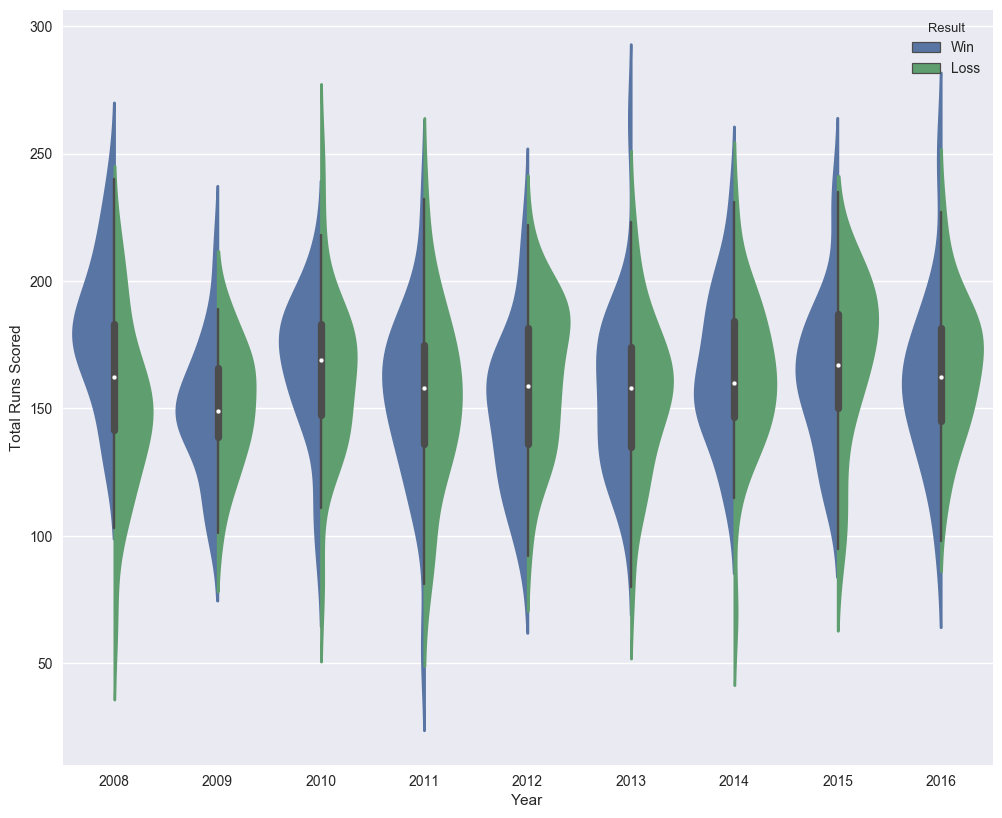

In [12]:
fig = plt.figure(figsize=(12, 10), dpi= 100)
ax = sns.violinplot(x='year', y='totalRunsScored', hue='Result', data=totals, split=True)
ax.set(xlabel='Year', ylabel='Total Runs Scored')
plt.show()

As expected, the distribution of winning first inning scores are more skewed to the higher end the losing scores. However, it isn't by that much because good batsmen aren't all that you need to successfully defend. Additionally, cricket games are finicky, especially the pitch. One day the pitch might be dry and hard, heavily favoring spin, and another day it might be the opposite, rendering it easier for the batsmen to utterly smash it out of the park. The year doesn't appear to be much of a factor, at least in determining the distribution of scores. How do the distrbution of wickets fare?

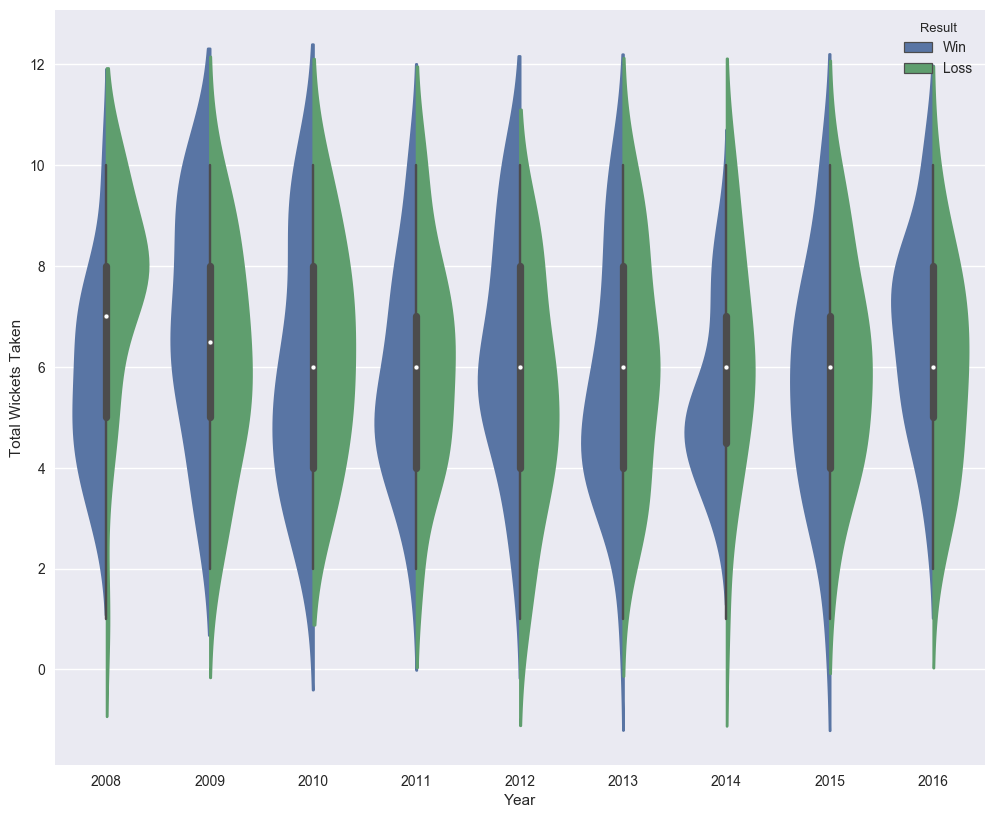

In [13]:
fig = plt.figure(figsize=(12, 10), dpi= 100)
ax = sns.violinplot(x='year', y='totalWicketsTaken', hue='Result', data=totals, split=True)
ax.set(xlabel='Year', ylabel='Total Wickets Taken')
plt.show()

From the plot, it appears that lower wickets falling corresponds to a higher chance of winning, but only slightly. This is because teams almost always have their best and most consistent batsmen bat first, with the bowlers who maybe aren't as proficient with the bat play later. Of course, there is no way to know if a bowler would do well in the higher order without putting him there. But it's a big gamble. Case in point this 2017 season: The Kolkata Knight Riders had one of their top batsmen, Chirs Lynn, suffer a shoulder injury in the first half of the season. So what the captain decided to do is move up one of the bowlers, Sunil Narine, to come in after the 3rd wicket. He did alright so the captain decided to have him come immediately. The result was superb batting performances every game, including a blistering 50 off just 12 balls. So it can pay off, but this machine learning algorithm can't pick up something that detailed immediately. You will need more sophisticated algorithms to decide whether to do something like that or not. 

Now let's do something a bit different: I will compare the winning scores against how many wickets fell during that game.

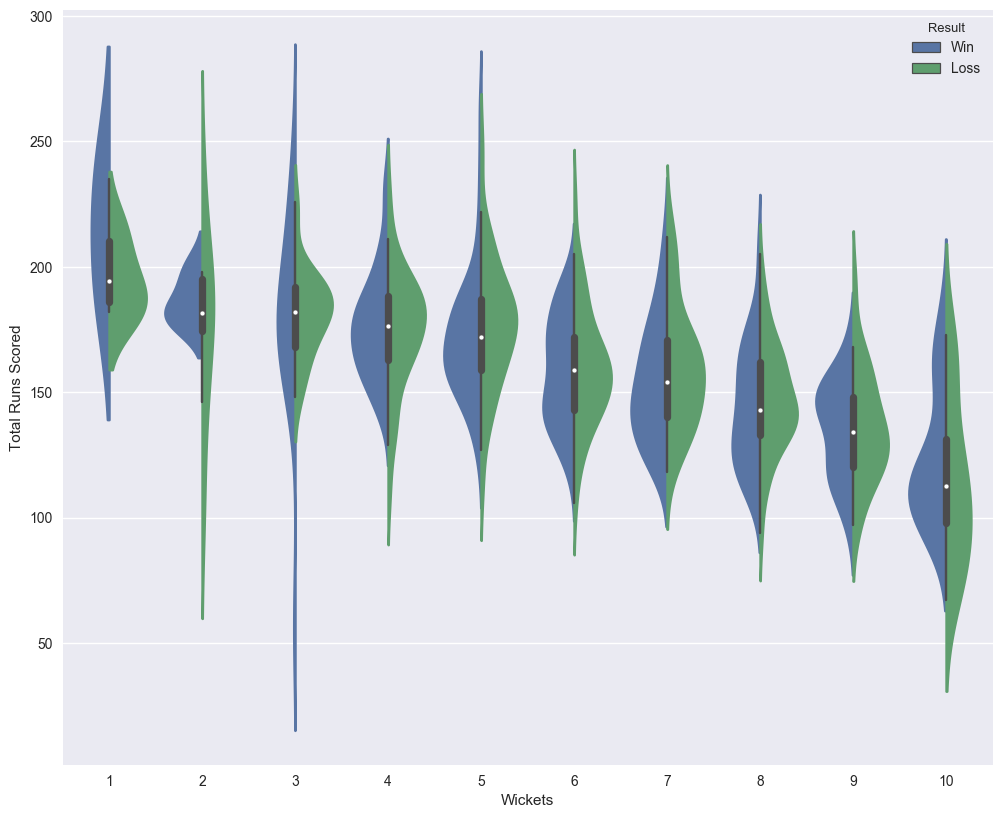

In [14]:
fig = plt.figure(figsize=(12, 10), dpi= 100)
ax = sns.violinplot(x='totalWicketsTaken', y='totalRunsScored', hue='Result', data=totals, split=True)
ax.set(xlabel='Wickets', ylabel='Total Runs Scored')
plt.show()

There is a clear a descending relationship between the number of wickets and the total runs scored. Additionally, the difference between the peaks of the win-loss distrubition grows slightly as the number of wickets grow. This is consistent with what I've talked about before with teams putting their best batsmen at the beginning. Now let's take a look at a few notable players and see how their win-loss distribution are. Some of the best batsmen are Chris Gayle, Virat Kohli, Suresh Raina, David Warner, Gautam Gambhir, and Rohit Sharma.

In [15]:
# Go through the batsmen table, and for each match,
# find the match in totals and assign Win-Loss
def batsmenWinLoss(row):
    return totals[totals['matchID'] == row['matchID']]['Result'].values[0]
batsmen['Result'] = batsmen.apply(batsmenWinLoss, axis=1)
# Filter the batsmen to include the batsmen mentioned above.
playersSub = batsmen[batsmen['batsman'].str.contains('CH Gayle|V Kohli|SK Raina|DA Warner|G Gambhir|RG Sharma')]

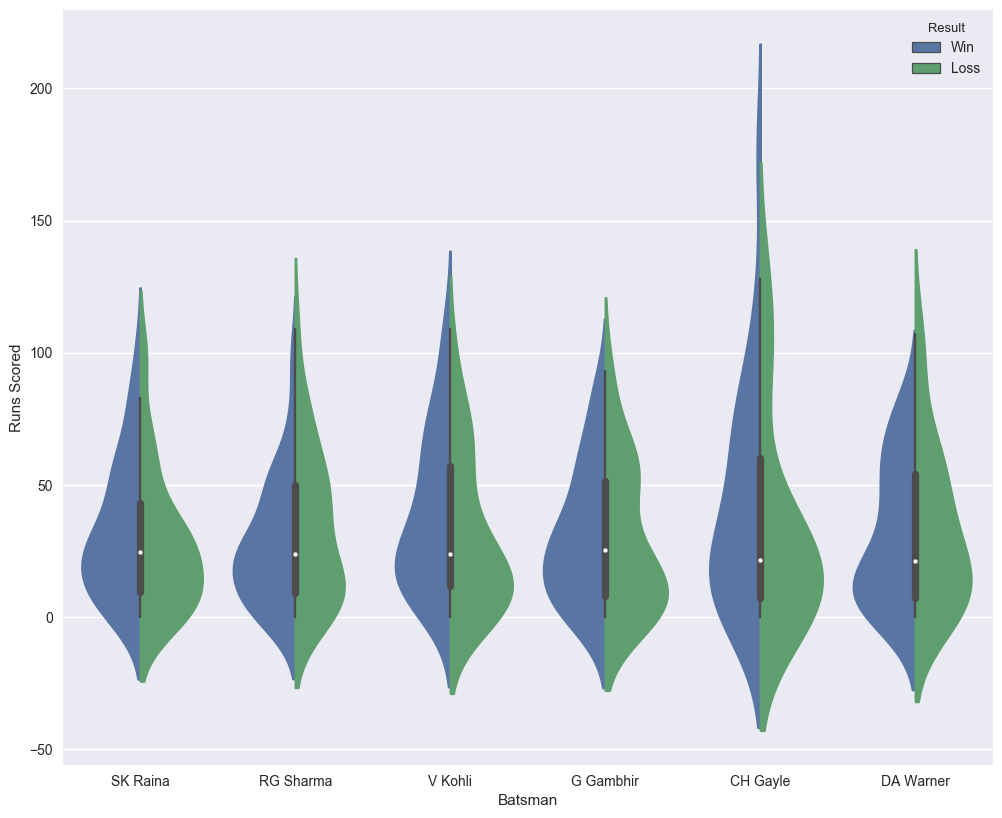

In [16]:
fig = plt.figure(figsize=(12, 10), dpi= 100)
ax = sns.violinplot(x='batsman', y='runsScored', hue='Result', data=playersSub, split=True)
ax.set(xlabel='Batsman', ylabel='Runs Scored')
plt.show()

Okay, the relationship is not as apparent as I had hoped. In Kohli's and Gambhir's, you can see a slight improvement of scores between matches that resulted in a win and a loss. Raina's and Sharma's distributions are about equal. Both Gayle's and Warner's win distributions have a high variance. This is equivalent to saying that both of these batsmen either score big or score small. However, it also implies that there are other decent batsmen that are able to pick up the pace, which is indeed true. For example, both Gayle and Kohli are on the same team. In Warner's case, a batsman by the name of Shikhar Dhawan is also very consistent.

## Hypothesis Testing and Machine Learning
So now that you have a good idea of some of the trends associated with winning scores, albeit some of them are a bit weak, let's actually try and predict the score given who's batting and bowling. Now, keep in mind that becaue we are dealing with players, we are going to have a vast amount columns.

In [17]:
batsmenCats = pd.get_dummies(data=batsmen, columns=['batsman'])
batsmenCats = batsmenCats.groupby(by='matchID')
batsmenCats = batsmenCats.sum()
# The runsScored and ballsFaced here are only from the batsmen. We want the actual score
batsmenCats.drop(labels=['runsScored', 'ballsFaced'], axis=1, inplace=True)
batsmenCats.head()

,batsman_A Ashish Reddy,batsman_A Chandila,batsman_A Chopra,batsman_A Flintoff,batsman_A Kumble,batsman_A Mishra,batsman_A Mithun,batsman_A Mukund,batsman_A Nehra,batsman_A Singh,batsman_A Symonds,batsman_A Uniyal,batsman_AA Bilakhia,batsman_AA Chavan,batsman_AA Jhunjhunwala,batsman_AB Agarkar,batsman_AB Dinda,batsman_AB McDonald,batsman_AB de Villiers,batsman_AC Blizzard,batsman_AC Gilchrist,batsman_AC Thomas,batsman_AC Voges,batsman_AD Mascarenhas,batsman_AD Mathews,batsman_AD Nath,batsman_AD Russell,batsman_AG Murtaza,batsman_AG Paunikar,batsman_AJ Finch,batsman_AL Menaria,batsman_AM Nayar,batsman_AM Rahane,batsman_AN Ahmed,batsman_AN Ghosh,batsman_AP Dole,batsman_AP Majumdar,batsman_AP Tare,batsman_AR Patel,batsman_AS Raut,batsman_AS Yadav,batsman_AT Rayudu,batsman_AUK Pathan,batsman_Anirudh Singh,batsman_Ankit Sharma,batsman_Anureet Singh,batsman_Azhar Mahmood,batsman_B Akhil,batsman_B Chipli,batsman_B Kumar,batsman_B Lee,batsman_B Sumanth,batsman_BA Bhatt,batsman_BAW Mendis,batsman_BB McCullum,batsman_BB Samantray,batsman_BB Sran,batsman_BCJ Cutting,batsman_BE Hendricks,batsman_BJ Haddin,batsman_BJ Hodge,batsman_BJ Rohrer,batsman_BMAJ Mendis,batsman_BR Dunk,batsman_Bipul Sharma,batsman_C Madan,batsman_C Munro,batsman_CA Ingram,batsman_CA Lynn,batsman_CA Pujara,batsman_CH Gayle,batsman_CH Morris,batsman_CJ Anderson,batsman_CJ Ferguson,batsman_CJ McKay,batsman_CK Kapugedera,batsman_CL White,batsman_CM Gautam,batsman_CR Brathwaite,batsman_D Kalyankrishna,batsman_D Salunkhe,batsman_D Wiese,batsman_D du Preez,batsman_DA Miller,batsman_DA Warner,batsman_DB Das,batsman_DB Ravi Teja,batsman_DE Bollinger,batsman_DH Yagnik,batsman_DJ Bravo,batsman_DJ Harris,batsman_DJ Hooda,batsman_DJ Hussey,batsman_DJ Jacobs,batsman_DJ Muthuswami,batsman_DJ Thornely,batsman_DJG Sammy,batsman_DL Vettori,batsman_DNT Zoysa,batsman_DPMD Jayawardene,batsman_DR Martyn,batsman_DR Smith,batsman_DS Kulkarni,batsman_DS Lehmann,batsman_DT Christian,batsman_DT Patil,batsman_DW Steyn,batsman_EJG Morgan,batsman_ER Dwivedi,batsman_F Behardien,batsman_F du Plessis,batsman_FH Edwards,batsman_FY Fazal,batsman_G Gambhir,batsman_GC Smith,batsman_GH Vihari,batsman_GJ Bailey,batsman_GJ Maxwell,batsman_GR Napier,batsman_Gurkeerat Singh,batsman_HH Gibbs,batsman_HH Pandya,batsman_HM Amla,batsman_HV Patel,batsman_Harbhajan Singh,batsman_Harmeet Singh,batsman_Harpreet Singh,batsman_I Malhotra,batsman_I Sharma,batsman_IK Pathan,batsman_IR Jaggi,batsman_Imran Tahir,batsman_Iqbal Abdulla,batsman_Ishan Kishan,batsman_J Arunkumar,batsman_J Botha,batsman_J Suchith,batsman_J Theron,batsman_J Yadav,batsman_JA Morkel,batsman_JC Buttler,batsman_JD Ryder,batsman_JD Unadkat,batsman_JDP Oram,batsman_JDS Neesham,batsman_JE Taylor,batsman_JEC Franklin,batsman_JH Kallis,batsman_JJ Bumrah,batsman_JO Holder,batsman_JP Duminy,batsman_JP Faulkner,batsman_JR Hopes,batsman_Jaskaran Singh,batsman_Joginder Sharma,batsman_K Goel,batsman_KA Pollard,batsman_KB Arun Karthik,batsman_KC Cariappa,batsman_KC Sangakkara,batsman_KD Karthik,batsman_KH Pandya,batsman_KJ Abbott,batsman_KK Cooper,batsman_KK Nair,batsman_KL Rahul,batsman_KM Jadhav,batsman_KP Pietersen,batsman_KS Williamson,batsman_KV Sharma,batsman_KW Richardson,batsman_Kamran Akmal,batsman_L Balaji,batsman_L Ronchi,batsman_LA Carseldine,batsman_LA Pomersbach,batsman_LJ Wright,batsman_LMP Simmons,batsman_LPC Silva,batsman_LR Shukla,batsman_LRPL Taylor,batsman_M Kaif,batsman_M Kartik,batsman_M Klinger,batsman_M Manhas,batsman_M Morkel,batsman_M Muralitharan,batsman_M Ntini,batsman_M Rawat,batsman_M Vijay,batsman_M Vohra,batsman_M de Lange,batsman_MA Agarwal,batsman_MA Khote,batsman_MA Starc,batsman_MC Henriques,batsman_MC Juneja,batsman_MD Mishra,batsman_MDKJ Perera,batsman_MEK Hussey,batsman_MF Maharoof,batsman_MG Johnson,batsman_MJ Clarke,batsman_MJ Guptill,batsman_MJ Lumb,batsman_MJ McClenaghan,batsman_MK Pandey,batsman_MK Tiwary,batsman_ML Hayden,batsman_MM Patel,batsman_MM Sharma,batsman_MN Samuels,batsman_MN van Wyk,batsman_MP Stoinis,bats

In [18]:
# Now do the same for the bowlers
bowlerCats = pd.get_dummies(data=bowlers, columns=['bowler'])
bowlerCats = bowlerCats.groupby(by='matchID')
bowlerCats = bowlerCats.sum()
# Here, just drop the number of ballsBowled. 
bowlerCats.drop(labels=['ballsBowled'], axis=1, inplace=True)
bowlerCats.head()

,runsGiven,wicketsTaken,bowler_A Ashish Reddy,bowler_A Chandila,bowler_A Flintoff,bowler_A Kumble,bowler_A Mishra,bowler_A Mithun,bowler_A Nehra,bowler_A Singh,bowler_A Symonds,bowler_A Uniyal,bowler_A Zampa,bowler_AA Chavan,bowler_AA Jhunjhunwala,bowler_AA Kazi,bowler_AA Noffke,bowler_AB Agarkar,bowler_AB Dinda,bowler_AB McDonald,bowler_AC Thomas,bowler_AC Voges,bowler_AD Mascarenhas,bowler_AD Mathews,bowler_AD Russell,bowler_AG Murtaza,bowler_AJ Finch,bowler_AL Menaria,bowler_AM Nayar,bowler_AM Rahane,bowler_AM Salvi,bowler_AN Ahmed,bowler_AP Dole,bowler_AR Patel,bowler_AS Rajpoot,bowler_AS Raut,bowler_AUK Pathan,bowler_Abdur Razzak,bowler_Anand Rajan,bowler_Ankit Sharma,bowler_Anureet Singh,bowler_Azhar Mahmood,bowler_B Akhil,bowler_B Geeves,bowler_B Kumar,bowler_B Laughlin,bowler_B Lee,bowler_BA Bhatt,bowler_BAW Mendis,bowler_BB Sran,bowler_BCJ Cutting,bowler_BE Hendricks,bowler_BJ Hodge,bowler_BMAJ Mendis,bowler_BW Hilfenhaus,bowler_Bipul Sharma,bowler_C Ganapathy,bowler_C Munro,bowler_C Nanda,bowler_CH Gayle,bowler_CH Morris,bowler_CJ Anderson,bowler_CJ Jordan,bowler_CJ McKay,bowler_CK Kapugedera,bowler_CK Langeveldt,bowler_CL White,bowler_CR Brathwaite,bowler_CRD Fernando,bowler_D Kalyankrishna,bowler_D Salunkhe,bowler_D Wiese,bowler_D du Preez,bowler_DAJ Bracewell,bowler_DB Ravi Teja,bowler_DE Bollinger,bowler_DJ Bravo,bowler_DJ Harris,bowler_DJ Hooda,bowler_DJ Hussey,bowler_DJ Muthuswami,bowler_DJ Thornely,bowler_DJG Sammy,bowler_DL Chahar,bowler_DL Vettori,bowler_DNT Zoysa,bowler_DP Nannes,bowler_DP Vijaykumar,bowler_DR Smith,bowler_DS Kulkarni,bowler_DT Christian,bowler_DW Steyn,bowler_FH Edwards,bowler_FY Fazal,bowler_GB Hogg,bowler_GD McGrath,bowler_GH Vihari,bowler_GJ Maxwell,bowler_GS Sandhu,bowler_Gagandeep Singh,bowler_Gurkeerat Singh,bowler_HH Pandya,bowler_HV Patel,bowler_Harbhajan Singh,bowler_Harmeet Singh,bowler_I Sharma,bowler_IC Pandey,bowler_IK Pathan,bowler_Imran Tahir,bowler_Iqbal Abdulla,bowler_J Botha,bowler_J Suchith,bowler_J Syed Mohammad,bowler_J Theron,bowler_J Yadav,bowler_JA Morkel,bowler_JD Ryder,bowler_JD Unadkat,bowler_JDP Oram,bowler_JDS Neesham,bowler_JE Taylor,bowler_JEC Franklin,bowler_JH Kallis,bowler_JJ Bumrah,bowler_JJ van der Wath,bowler_JM Kemp,bowler_JO Holder,bowler_JP Duminy,bowler_JP Faulkner,bowler_JR Hopes,bowler_JW Hastings,bowler_Jaskaran Singh,bowler_Joginder Sharma,bowler_K Goel,bowler_K Santokie,bowler_K Upadhyay,bowler_KA Pollard,bowler_KAJ Roach,bowler_KC Cariappa,bowler_KH Pandya,bowler_KJ Abbott,bowler_KK Cooper,bowler_KMDN Kulasekara,bowler_KP Appanna,bowler_KP Pietersen,bowler_KS Williamson,bowler_KV Sharma,bowler_KW Richardson,bowler_Kamran Khan,bowler_Karanveer Singh,bowler_Kuldeep Yadav,bowler_L Ablish,bowler_L Balaji,bowler_LA Carseldine,bowler_LJ Wright,bowler_LR Shukla,bowler_LRPL Taylor,bowler_M Ashwin,bowler_M Kartik,bowler_M Manhas,bowler_M Morkel,bowler_M Muralitharan,bowler_M Ntini,bowler_M Vijay,bowler_M de Lange,bowler_MA Khote,bowler_MA Starc,bowler_MC Henriques,bowler_MF Maharoof,bowler_MG Johnson,bowler_MG Neser,bowler_MJ Clarke,bowler_MJ McClenaghan,bowler_MK Tiwary,bowler_MM Patel,bowler_MM Sharma,bowler_MN Samuels,bowler_MP Stoinis,bowler_MR Marsh,bowler_MS Gony,bowler_Mohammad Asif,bowler_Mohammad Hafeez,bowler_Mohammed Shami,bowler_Mustafizur Rahman,bowler_ND Doshi,bowler_NL McCullum,bowler_NLTC Perera,bowler_NM Coulter-Nile,bowler_P Amarnath,bowler_P Awana,bowler_P Kumar,bowler_P Negi,bowler_P Parameswaran,bowler_P Prasanth,bowler_P Sahu,bowler_P Suyal,bowler_PC Valthaty,bowler_PD Collingwood,bowler_PJ Cummins,bowler_PJ Sangwan,bowler_PM Sarvesh Kumar,bowler_PP Chawla,bowler_PP Ojha,bowler_PV Tambe,bowler_Pankaj Singh,bowler_Parvez Rasool,bowler_R Ashwin,bowler_R Bhatia,bowler_R Dhawan,bowler_R McLaren,bowler_R Ninan,bowler_R Rampaul,bowler_R Sathish,bowler_R Sharma,bowler_R Shukla,bowler_R Tewatia,bowler_R Vinay Kumar,bowler_RA Jadeja,bowler_RE van der Merwe,bowler_RG More,bowler_RG Sharma,bowler_RJ Harris,bowler_RJ Peterson,bowler_RN ten Do

In [19]:
# Now combine the batsmenCats and bowlerCats into giant dataframe
fullData = bowlerCats.join(batsmenCats)
fullData = fullData.rename(columns = {'runsGiven': 'totalRuns', 'wicketsTaken': 'wicketsFallen'})
fullData.head()

,totalRuns,wicketsFallen,bowler_A Ashish Reddy,bowler_A Chandila,bowler_A Flintoff,bowler_A Kumble,bowler_A Mishra,bowler_A Mithun,bowler_A Nehra,bowler_A Singh,bowler_A Symonds,bowler_A Uniyal,bowler_A Zampa,bowler_AA Chavan,bowler_AA Jhunjhunwala,bowler_AA Kazi,bowler_AA Noffke,bowler_AB Agarkar,bowler_AB Dinda,bowler_AB McDonald,bowler_AC Thomas,bowler_AC Voges,bowler_AD Mascarenhas,bowler_AD Mathews,bowler_AD Russell,bowler_AG Murtaza,bowler_AJ Finch,bowler_AL Menaria,bowler_AM Nayar,bowler_AM Rahane,bowler_AM Salvi,bowler_AN Ahmed,bowler_AP Dole,bowler_AR Patel,bowler_AS Rajpoot,bowler_AS Raut,bowler_AUK Pathan,bowler_Abdur Razzak,bowler_Anand Rajan,bowler_Ankit Sharma,bowler_Anureet Singh,bowler_Azhar Mahmood,bowler_B Akhil,bowler_B Geeves,bowler_B Kumar,bowler_B Laughlin,bowler_B Lee,bowler_BA Bhatt,bowler_BAW Mendis,bowler_BB Sran,bowler_BCJ Cutting,bowler_BE Hendricks,bowler_BJ Hodge,bowler_BMAJ Mendis,bowler_BW Hilfenhaus,bowler_Bipul Sharma,bowler_C Ganapathy,bowler_C Munro,bowler_C Nanda,bowler_CH Gayle,bowler_CH Morris,bowler_CJ Anderson,bowler_CJ Jordan,bowler_CJ McKay,bowler_CK Kapugedera,bowler_CK Langeveldt,bowler_CL White,bowler_CR Brathwaite,bowler_CRD Fernando,bowler_D Kalyankrishna,bowler_D Salunkhe,bowler_D Wiese,bowler_D du Preez,bowler_DAJ Bracewell,bowler_DB Ravi Teja,bowler_DE Bollinger,bowler_DJ Bravo,bowler_DJ Harris,bowler_DJ Hooda,bowler_DJ Hussey,bowler_DJ Muthuswami,bowler_DJ Thornely,bowler_DJG Sammy,bowler_DL Chahar,bowler_DL Vettori,bowler_DNT Zoysa,bowler_DP Nannes,bowler_DP Vijaykumar,bowler_DR Smith,bowler_DS Kulkarni,bowler_DT Christian,bowler_DW Steyn,bowler_FH Edwards,bowler_FY Fazal,bowler_GB Hogg,bowler_GD McGrath,bowler_GH Vihari,bowler_GJ Maxwell,bowler_GS Sandhu,bowler_Gagandeep Singh,bowler_Gurkeerat Singh,bowler_HH Pandya,bowler_HV Patel,bowler_Harbhajan Singh,bowler_Harmeet Singh,bowler_I Sharma,bowler_IC Pandey,bowler_IK Pathan,bowler_Imran Tahir,bowler_Iqbal Abdulla,bowler_J Botha,bowler_J Suchith,bowler_J Syed Mohammad,bowler_J Theron,bowler_J Yadav,bowler_JA Morkel,bowler_JD Ryder,bowler_JD Unadkat,bowler_JDP Oram,bowler_JDS Neesham,bowler_JE Taylor,bowler_JEC Franklin,bowler_JH Kallis,bowler_JJ Bumrah,bowler_JJ van der Wath,bowler_JM Kemp,bowler_JO Holder,bowler_JP Duminy,bowler_JP Faulkner,bowler_JR Hopes,bowler_JW Hastings,bowler_Jaskaran Singh,bowler_Joginder Sharma,bowler_K Goel,bowler_K Santokie,bowler_K Upadhyay,bowler_KA Pollard,bowler_KAJ Roach,bowler_KC Cariappa,bowler_KH Pandya,bowler_KJ Abbott,bowler_KK Cooper,bowler_KMDN Kulasekara,bowler_KP Appanna,bowler_KP Pietersen,bowler_KS Williamson,bowler_KV Sharma,bowler_KW Richardson,bowler_Kamran Khan,bowler_Karanveer Singh,bowler_Kuldeep Yadav,bowler_L Ablish,bowler_L Balaji,bowler_LA Carseldine,bowler_LJ Wright,bowler_LR Shukla,bowler_LRPL Taylor,bowler_M Ashwin,bowler_M Kartik,bowler_M Manhas,bowler_M Morkel,bowler_M Muralitharan,bowler_M Ntini,bowler_M Vijay,bowler_M de Lange,bowler_MA Khote,bowler_MA Starc,bowler_MC Henriques,bowler_MF Maharoof,bowler_MG Johnson,bowler_MG Neser,bowler_MJ Clarke,bowler_MJ McClenaghan,bowler_MK Tiwary,bowler_MM Patel,bowler_MM Sharma,bowler_MN Samuels,bowler_MP Stoinis,bowler_MR Marsh,bowler_MS Gony,bowler_Mohammad Asif,bowler_Mohammad Hafeez,bowler_Mohammed Shami,bowler_Mustafizur Rahman,bowler_ND Doshi,bowler_NL McCullum,bowler_NLTC Perera,bowler_NM Coulter-Nile,bowler_P Amarnath,bowler_P Awana,bowler_P Kumar,bowler_P Negi,bowler_P Parameswaran,bowler_P Prasanth,bowler_P Sahu,bowler_P Suyal,bowler_PC Valthaty,bowler_PD Collingwood,bowler_PJ Cummins,bowler_PJ Sangwan,bowler_PM Sarvesh Kumar,bowler_PP Chawla,bowler_PP Ojha,bowler_PV Tambe,bowler_Pankaj Singh,bowler_Parvez Rasool,bowler_R Ashwin,bowler_R Bhatia,bowler_R Dhawan,bowler_R McLaren,bowler_R Ninan,bowler_R Rampaul,bowler_R Sathish,bowler_R Sharma,bowler_R Shukla,bowler_R Tewatia,bowler_R Vinay Kumar,bowler_RA Jadeja,bowler_RE van der Merwe,bowler_RG More,bowler_RG Sharma,bowler_RJ Harris,bowler_RJ Peterson,bowler_RN ten D

### Runs Scored
For predicting the runs, I will doing a continuous prediction. For the wickets taken, I will be doing classification because of the relatively small number of 'classes' and the gaps between the classes are a greater fraction of the range. The prediction method will be Random Forest Regression/Classification. One note though you might have noticed: The number of features is actually more than the number of observations. Additionally, there will also be some multi-collinearity going on as players will be on the same team. This is one reason that I chose random forest as the prediction method. Random forests are good at handling situations where features outnumber the observations as well as multi-collinearity.

In [20]:
# X is everything except the first two columns
X = fullData.drop(labels=['totalRuns', 'wicketsFallen'], axis=1)
# Y is the reverse
Y = fullData['totalRuns']

# Two things: do a cross-validation and also a full model

rfr = RandomForestRegressor(n_estimators=500,n_jobs=50)
scores = cross_val_score(rfr, X, Y, cv=20)

rfr.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=50, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

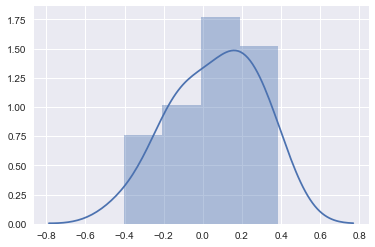

In [21]:
sns.distplot(scores)

Okay so the mean square error scores are bit skewed to the left. But with only 20 cross-validation scores, it's hard to be conclusive. Your results may vary.

So how do we evaluate a random forest regression model. Because it's regression, one way is to use an F-test. However, because our features outnumber the observations, the degrees of freedom $n-p$ would be negative. Thus, an F-test is impossible. The other option, which I'm going to use, is look at the importance values for each variable and see which importance values are significant. Anything that is significant is notice to the teams and captains which players they should play. I will be referencing this presentation: https://eeecon.uibk.ac.at/~zeileis/papers/Lifestat-2008.pdf

According to the presentation, each importance value should be scaled by its standard deviation divided by the square root of how many trees we have. These would be the z-scores of each importance value. The null hypothesis we will be testing is that each z-score isn't significantly different from 0 i.e.
$$ H_0: z_i = 0$$
$$ H_a: z_i \neq 0$$
for each feature $i$.

In [22]:
# The importance values are in held in the model's feature_importances field.
importances = rfr.feature_importances_
# Do the appropriate scaling
zScores = importances / (np.std(importances) / np.sqrt(500))

Now to choose the significance level. We have over 400 batsmen and about 200 players have bowled as well. We want to be able to keep the key players that consistently make an impact in the games. Thus, I will keep a low cut-off signicifance of 0.001.

In [23]:
keeping = X.columns[1 - norm.cdf(zScores) < 0.001].values
Xcutdown = X[keeping]
# Check to make sure observations outnumber variables
print('Number of matches:', len(Xcutdown))
print('Number of players:', len(Xcutdown.columns))

Number of matches: 562
Number of players: 428


Excellent, now re-run regression on this cut down dataset, and do an F-test on this to test significance, with a significance level of 0.01.

In [24]:
cutDownRFR = RandomForestRegressor(n_estimators=500, n_jobs=50)
cutDownRFR.fit(Xcutdown, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=50, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [25]:
predictions = cutDownRFR.predict(Xcutdown)
mean = np.mean(predictions)
SSM = np.sum((predictions - mean) ** 2)
SSE = np.sum((Y - predictions) ** 2)
MSM = SSM / (len(Xcutdown.columns))
MSE = SSE / (len(X) - len(Xcutdown.columns) - 1)
F = MSM / MSE
1 - f.cdf(F, len(Xcutdown.columns), len(X) - len(Xcutdown.columns) - 1)

0.0055272707376321506

Because 0.0059 < 0.01, I will reject the null hypothesis and conclude that this model does indeed do a better job of regression than a random model. However, this only implies that the model is not useless. We will need a more comprehensive test to see whether this model is adequate. At this point, I will be done for predicting the number of runs scored. Up next, I will predict the number of wickets that have fallen. This is a classification problem, and hence much more direct to evaluate.

### Wickets Taken
Because the number of wickets taken are very volatile (one game only 1 person may have gotten out, but the next time the players play against each other, 6 may have gotten out), I'm not expecting the accuracy scores to be too high. For this reason, it will be more useful to compare multiple models against each other and see which one is the best. I will try k-Nearest Neighbors, Random Forests, and Neural Networks.

In [26]:
# First choose which k <= 20 yields the highest score
maxScore = 0
maxK = 1
for k in range(1, 21):
    kNN = KNeighborsClassifier(n_neighbors=k, n_jobs=50)
    kNN.fit(X, Y)
    if metrics.accuracy_score(kNN.predict(X), Y) > maxScore:
        maxScore = metrics.accuracy_score(kNN.predict(X), Y)
        maxK = k

In [27]:
# X will still be the same, Y is now the wicketsFallen column
Y = fullData['wicketsFallen']
# Create 20 cross validation scores for each method
rfc = RandomForestClassifier(n_estimators=500, n_jobs=50)
kNN = KNeighborsClassifier(n_neighbors=maxK, n_jobs=50)
# Finding the hidden layer sizes is tricky, and it's also hard to
# optimize as well. In this case, I will be choosing a 10 x 11,
# for 10 wickets and 11 players
neural = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10,)*11)

# Compute the scores, this might take a while
kNNscores = cross_val_score(kNN, X, Y, cv=20)
RFCscores = cross_val_score(rfc, X, Y, cv=20)
neuralScores = cross_val_score(neural, X, Y, cv=20)

c:\users\mughi\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)
c:\users\mughi\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)
c:\users\mughi\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=20.
  % (min_groups, self.n_splits)), Warning)


Don't worry too much about the warnings. That is simply saying that the class with the least members numbers only 6, which may or may not be in the split. With only this many matches and the rarity at which everyone or no one gets out, this is unavoidable. Now let's view the scores.

In [28]:
kNNscores

array([ 0.25      ,  0.28125   ,  0.125     ,  0.16129032,  0.23333333,
        0.16666667,  0.27586207,  0.24137931,  0.34482759,  0.13793103,
        0.10344828,  0.24137931,  0.03571429,  0.15384615,  0.12      ,
        0.12      ,  0.08      ,  0.08333333,  0.16666667,  0.16666667])

In [29]:
RFCscores

array([ 0.28125   ,  0.1875    ,  0.21875   ,  0.22580645,  0.26666667,
        0.23333333,  0.31034483,  0.31034483,  0.34482759,  0.27586207,
        0.31034483,  0.24137931,  0.10714286,  0.23076923,  0.2       ,
        0.2       ,  0.16      ,  0.16666667,  0.125     ,  0.16666667])

In [30]:
neuralScores

array([ 0.1875    ,  0.15625   ,  0.25      ,  0.22580645,  0.26666667,
        0.2       ,  0.27586207,  0.13793103,  0.17241379,  0.17241379,
        0.06896552,  0.10344828,  0.17857143,  0.19230769,  0.08      ,
        0.16      ,  0.12      ,  0.125     ,  0.16666667,  0.25      ])

As I stated before, the scores aren't very high at all. From inspection, it appears that Random Forest did better than both k-Nearest Neighbors and neural networks. To quantify 'did better', let's do a paired t-test on each pair.

In [31]:
# Now run a paired t-test
kNNRFCstat, kNNRFCp = ttest_rel(kNNscores, RFCscores)
kNNneuralStat, kNNneuralP = ttest_rel(kNNscores, neuralScores)
RFCneuralStat, RFCneuralP = ttest_rel(RFCscores, neuralScores)
print('p-value of k-Nearest Neighbors and Random Forest:\t', kNNRFCp)
print('p-value of k-Nearest Neighbors and Neural Network:\t', kNNneuralP)
print('p-value of Random Forest and Neural Network:\t', RFCneuralP)

p-value of k-Nearest Neighbors and Random Forest:	 0.0013071452031
p-value of k-Nearest Neighbors and Neural Network:	 0.997510054326
p-value of Random Forest and Neural Network:	 0.0109441965684


The p-values agree with our inspection earlier. In addition, we can also see that k-Nearest Neighbors and neural networks didn't perform significantly different from each other. From this, we should deduce that the random forest model is the best bet when predicting how many batsmen will get out.

## Conclusion
We have seen it is possible to predict how many runs a team will score through regression and how many wickets will fall during a match. In both of these, random forests reigned supreme. However, because we only had binary values for each person, the predictions are not as strong as they could be, in my opinion, although they are still significant, as per the tests that were done. One weakness with this model is that it will not be able to evaluate rookies in their first year very well. They haven't played past IPL matches and so one will have to look into other types of matches. Another weakness is that it can't predict which team will win and which will lose or what constitutes a 'good' score. As showed in the data analysis section, the winning scores are generally distributed higher but not by much. A team with a good bowling attack may not need to score too much to be competitive. 

Obviously, I left out many things that can be possible with this dataset. The end goal, hypothetically, is for the captain and the coach to use this model to see which squad has the best chance to put runs on the board before a match. After a match, you can do a simple comparison to see if you beat or didn't beat the prediction. One extension is to factor in the number of balls each batsmen has hit and predict the score based on that. This can help in seeing whether the batsmen underperformed or overperformed in the match. It can also help in seeing if your lower-order batsmen made up for upper-order batsmen who may have gotten out very quickly. 

One can also delve in much deeper rather than predict the outcome. An important question would be to ask which is the right bowler to bowl to a given pair of batsmen to ensure as low score as possible and even getting them out. This is based on many things, such as if the bowler is right/left-handed, if he is a spinner/fast bowler, even which over it is as well because the first 6 overs of an IPL match is known as the powerplay, with only 3 players near the boundary allowed.

Anyway, hope you enjoyed reading my project. If you're interested, the final in this year's IPL is scheduled to be Sunday the 21st at 10:30 AM local time. Follow ball-by-ball on http://www.iplt20.com/.